## Selecting the most prominent mass to charge ratios
The goal of this notebook is to create usable features. As the plots in EDA.ipynb (see folder EDA and Preprocessing) suggest, not all mass to charge ratios are equally abundant. We want to create features by using the most prominent ones, in the sense of those which give (renormalized) abundance curves having the largest sum of mean and standard deviation. 

At the end we augment the train_labels and the val_labels files with features, namely for each of the 5 most prominent mass-to-charge ratios we record the peak abundance, the temperature at which this happens, and the total sum of mean and standard deviation of the corresponding renormalized abundance curve. The resulting dataframes are saved into csv files for easy access.

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We first import the dictionary with the paths corresponding to each sample

In [126]:
import pickle

with open('../Data/train_files.pickle', 'rb') as f:
    train_files = pickle.load(f)

with open('../Data/val_files.pickle', 'rb') as f:
    val_files = pickle.load(f)

Now we will write a function that picks out the most prominent lines

In [127]:
def find_relevant_ratios(df,num_of_ratios):
    """
    This function takes in a dataframe with a zero_one_rescale column and the number of ratios we want to keep and
    returns a list with the num_of_ratios most prominent mass to charge ratios
    """

    # The following variable stores all existing ratios in a list, after removing duplicates

    existing_ratios = list(set(df["m/z"].values))  
    

    # the fist column will store the value of m/z, the second the corresponding mean and the third the std_dev. The fourth is the sum.

    comp_table = np.zeros((len(existing_ratios),4)) 

    for i,ratio_value in enumerate(existing_ratios):
        
        comp_table[i,0] = ratio_value 
        
        df_temp = df.loc[df["m/z"]==ratio_value] # look at the subset of the dataframe corresponding to the ratio
        
        comp_table[i,1] = np.nanmean(df_temp.zero_one_rescale.values)
        comp_table[i,2] = np.nanstd(df_temp.zero_one_rescale.values)
        comp_table[i,3] = comp_table[i,1]+comp_table[i,2]
        
        del df_temp
    
    # now we sort the table with respect to highest sum of mean and standard deviation
    
    comp_table[comp_table[:,3].argsort()[::-1]]

    # we return the num_of_ratios most relevant values of m/z

    return comp_table[comp_table[:,3].argsort()[::-1]][:num_of_ratios,0]



Check that it works:

In [128]:

from preprocess import preprocess

df = pd.read_csv(train_files['S0025'])

df_mod = preprocess(df)

print(find_relevant_ratios(df_mod,8))

[28. 44. 32. 16. 18.  2. 17. 12.]


Now create plots to see what's going on

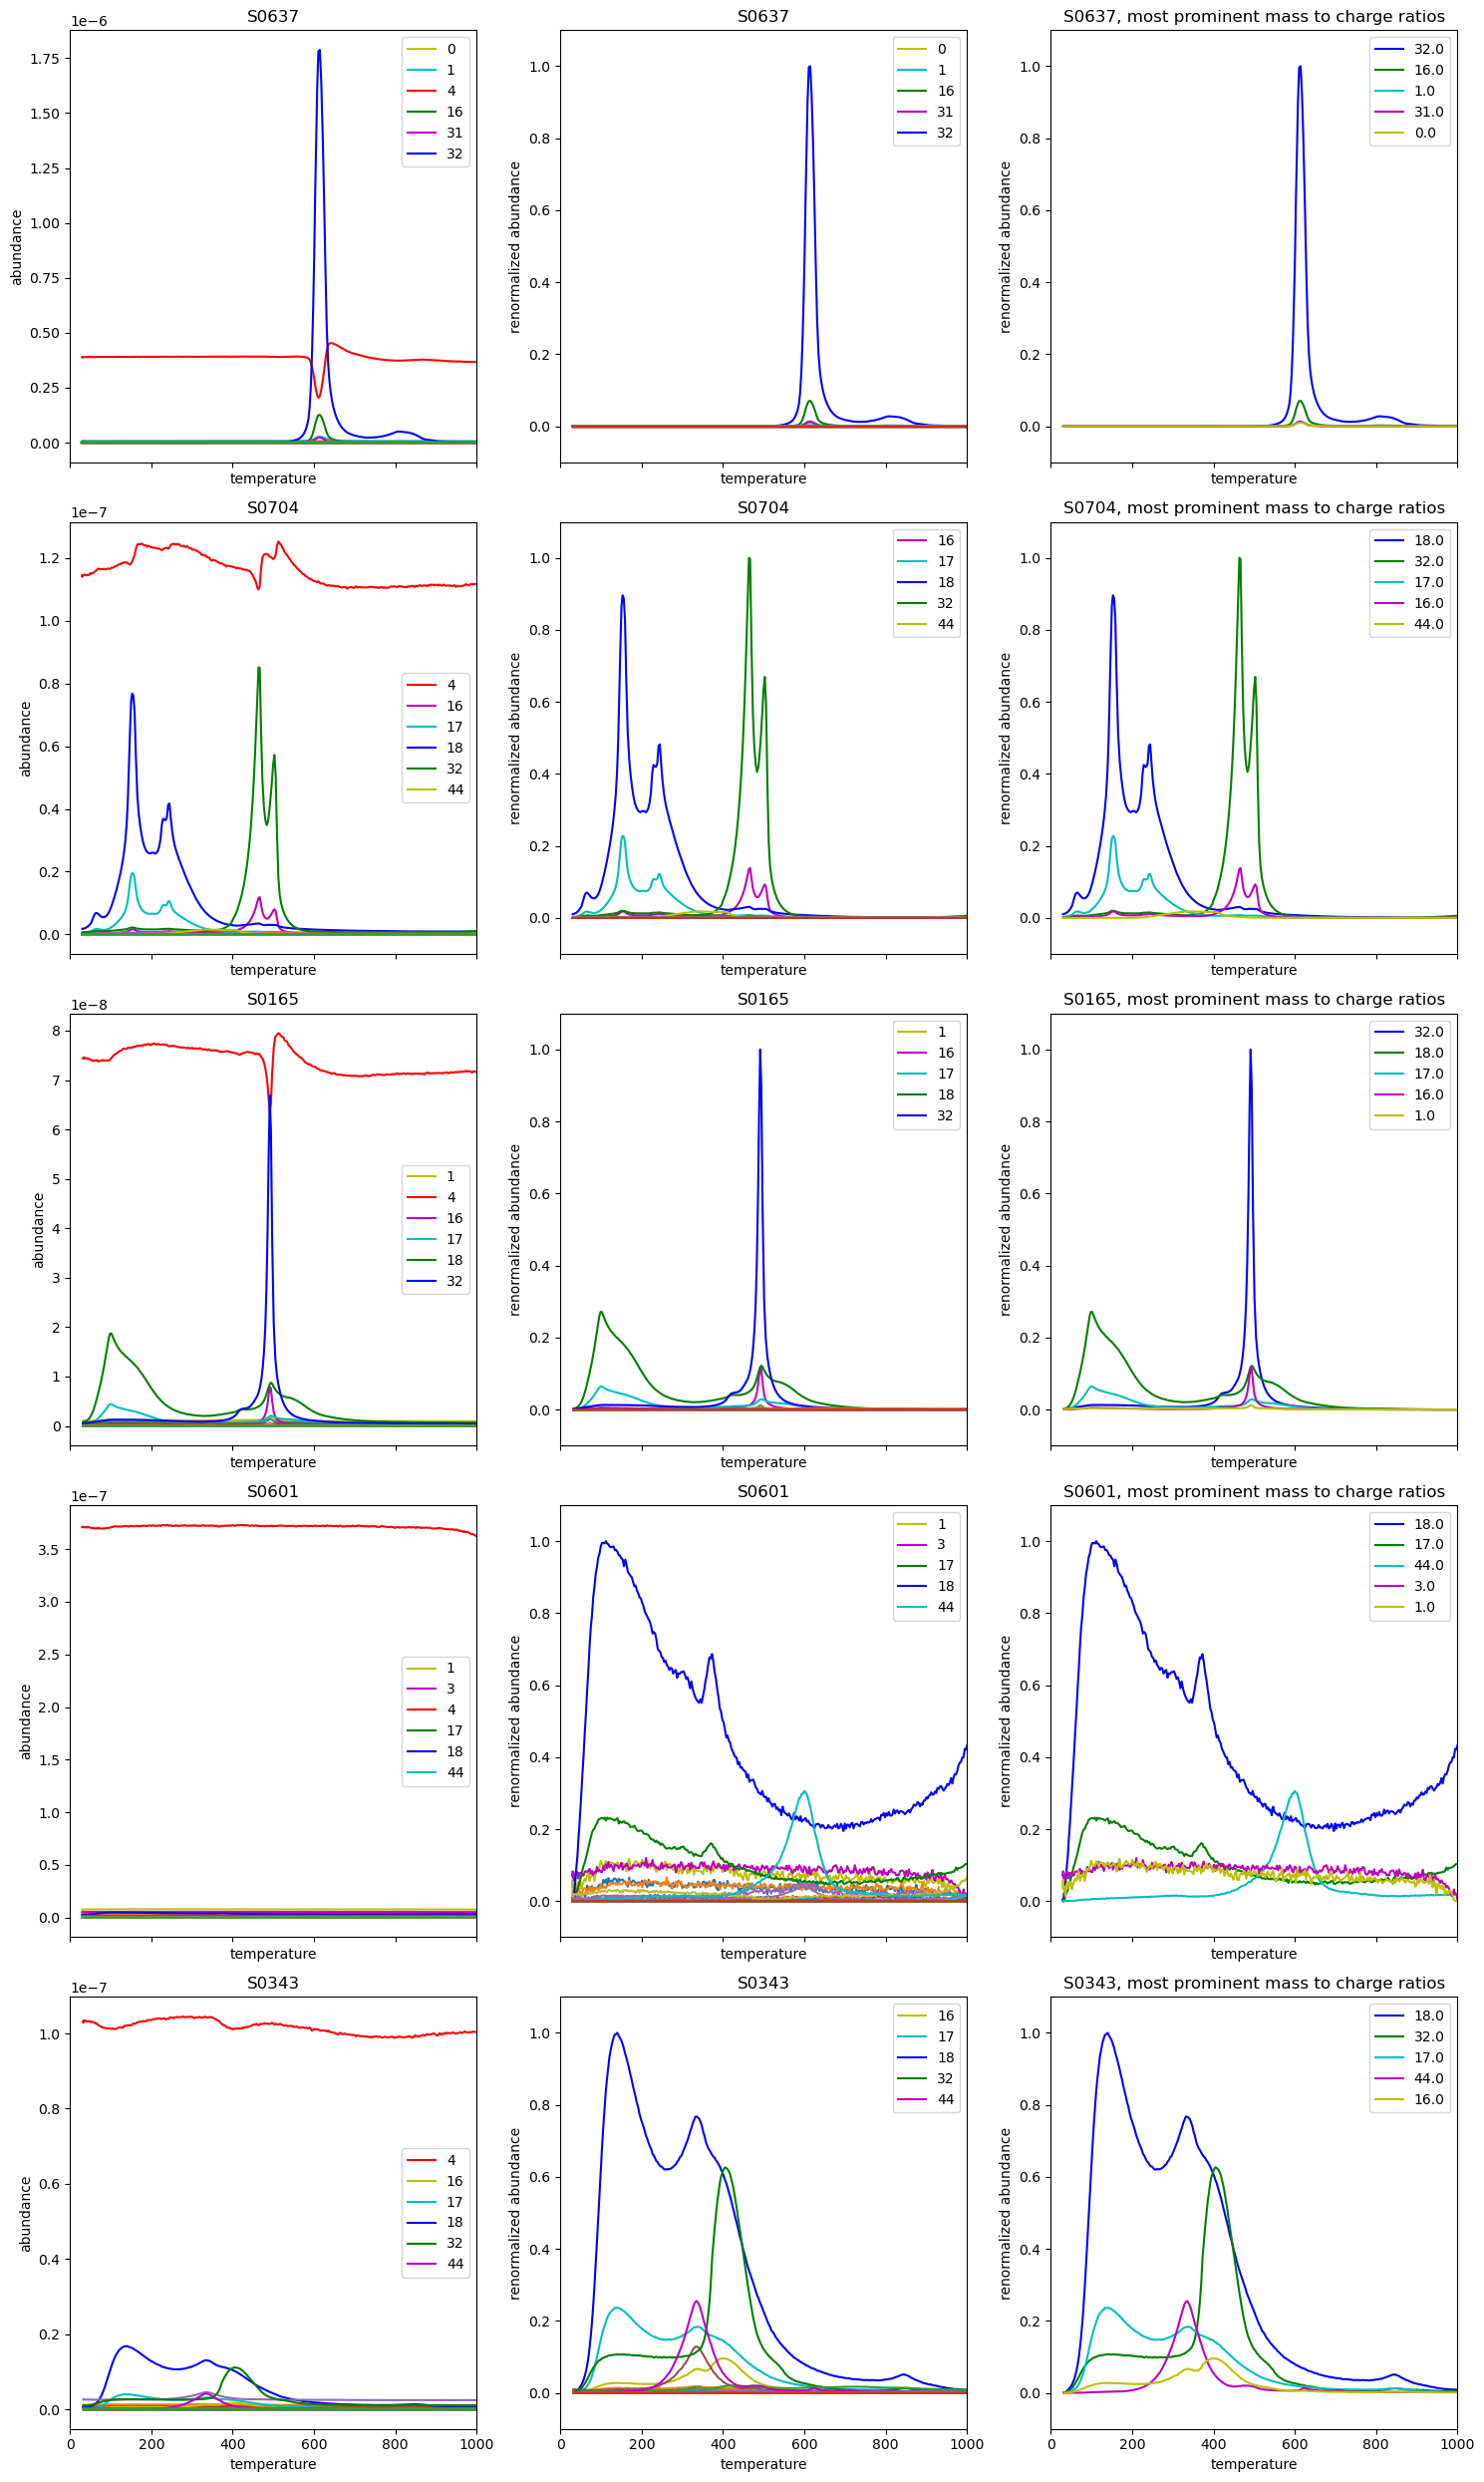

In [129]:
import warnings
warnings.filterwarnings("ignore") # ignore some annoying warnings

import random

num_samples = 5

# create a list of samples to plot

random.seed(69100)

samples_list = random.sample(list(train_files.keys()),num_samples)

colors = ['b','g','c','m','y','r']

num_ratios = 5 # number of most prominent ratios we want to include


num_columns = 3

fig, ax = plt.subplots(num_samples,num_columns,sharex = True,figsize = (5*num_columns,5*num_samples))


for i, sample in enumerate(samples_list):

    # Load the dataframe

    df = pd.read_csv(train_files[sample])

    # Preprocess it

    df_mod = preprocess(df)

    relevant_ratios = find_relevant_ratios(df_mod,num_ratios)
    

    plt.subplot(num_samples,num_columns,num_columns*i+1)    

    for mz in range(0,99):
        X = df[df['m/z'] == mz].temp
        y = df[df['m/z'] == mz].abundance

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz in np.append(relevant_ratios,[4]):
            plt.plot(X,y,label = str(mz),color = colors[int(np.where(np.append(relevant_ratios,[4])==mz)[0])])
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('abundance')
        plt.xlim(0,1000)
        plt.title(sample)

        plt.legend()       
        
        plt.yscale('linear')

        # This column shows the rescaled abundances for all charge to mass ratios
    
    plt.subplot(num_samples,num_columns,num_columns*i+2)    

    for mz in range(0,99):
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].zero_one_rescale

        # We show a legend only for the first few values of mz in order to not clutter the picture
             
        if mz in relevant_ratios:
            plt.plot(X,y,label = str(mz),color = colors[int(np.where(relevant_ratios==mz)[0])])
        else:
            plt.plot(X,y,label = "")       
        

        plt.xlabel('temperature')
        plt.ylabel('renormalized abundance')
        plt.xlim(0,1000)
        plt.ylim(-0.1,1.1)
        plt.title(sample)
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')

    plt.subplot(num_samples,num_columns,num_columns*i+3)
    
    for mz in relevant_ratios:
        X = df_mod[df_mod['m/z'] == mz].temp
        y = df_mod[df_mod['m/z'] == mz].zero_one_rescale

        # We show all legends            
        
        plt.plot(X,y,label = str(mz),color = colors[int(np.where(relevant_ratios==mz)[0])])
        
        
        plt.xlabel('temperature')
        plt.ylabel('renormalized abundance')
        plt.xlim(0,1000)
        plt.ylim(-0.1,1.1)
        plt.title(sample+", most prominent mass to charge ratios")
        
        # ax[i] = plt.show()
    
        plt.legend()


    
        plt.yscale('linear')

    del df


# this is for cosmetic purposes

fig.tight_layout()     
    
fig.show()




## Augmenting the train_labels and the val_labels files
We will add columns to the train_labels and val_labels file corresponding to the most prominent ratios, at what temperature they peak, what the peak is, and the sum of the average and the std_dev of the rescaled abundance

In [130]:
train_labels = pd.read_csv("../Data/train_labels.csv",index_col="sample_id")
val_labels = pd.read_csv("../Data/val_labels.csv",index_col="sample_id")
train_labels

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0
S0001,0,1,0,0,0,0,0,0,0,0
S0002,0,0,0,0,0,1,0,0,0,0
S0003,0,1,0,1,0,0,0,0,1,0
S0004,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
S0749,0,0,0,0,0,0,0,0,0,0
S0750,0,0,0,0,0,0,1,0,0,0
S0751,0,0,0,0,0,0,0,1,0,0


In [131]:
val_labels

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0,0,0,0,0,0,0,0,0,0
S0767,0,0,0,0,0,0,0,0,0,0
S0768,1,0,0,0,0,0,1,1,0,0
S0769,0,0,0,0,0,1,0,0,1,0
S0770,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
S1054,0,0,0,0,0,0,0,0,0,0
S1055,0,0,0,0,0,0,0,1,0,0
S1056,0,0,0,0,1,0,0,0,0,0


Add the relevant columns to it, also create a list with the labels so that we can easily access the columns corresponding to each ratio.

In [132]:
A = [] # the i-th element of this list will contain all features corresponding to the i-th ratio
Pa = [] # Each element of this list will contain peak abundance across ratios
Pt = [] # Each element of this list will contain peak abundance across ratios
PMS = [] # Each element of this list will contain peak mean+std across ratios

num_ratios = 5

for i in range(num_ratios):
        
        train_labels[str(i+1)+'_ratio'] = np.nan
        train_labels[str(i+1)+'_ratio_peak_temp'] = np.nan
        train_labels[str(i+1)+'_ratio_peak_abund'] = np.nan
        train_labels[str(i+1)+'_ratio_meanstd_abund'] = np.nan

        val_labels[str(i+1)+'_ratio'] = np.nan
        val_labels[str(i+1)+'_ratio_peak_temp'] = np.nan
        val_labels[str(i+1)+'_ratio_peak_abund'] = np.nan
        val_labels[str(i+1)+'_ratio_meanstd_abund'] = np.nan

        A.append([str(i+1)+'_ratio',str(i+1)+'_ratio_peak_temp',str(i+1)+'_ratio_peak_abund',str(i+1)+'_ratio_meanstd_abund'])
        Pt.append(str(i+1)+'_ratio_peak_temp')
        Pa.append(str(i+1)+'_ratio_peak_abund')
        PMS.append(str(i+1)+'_ratio_meanstd_abund')

train_labels


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,...,3_ratio_peak_abund,3_ratio_meanstd_abund,4_ratio,4_ratio_peak_temp,4_ratio_peak_abund,4_ratio_meanstd_abund,5_ratio,5_ratio_peak_temp,5_ratio_peak_abund,5_ratio_meanstd_abund
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0001,0,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0002,0,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0003,0,1,0,1,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0004,0,0,0,1,0,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0749,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0750,0,0,0,0,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0751,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
val_labels

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,...,3_ratio_peak_abund,3_ratio_meanstd_abund,4_ratio,4_ratio_peak_temp,4_ratio_peak_abund,4_ratio_meanstd_abund,5_ratio,5_ratio_peak_temp,5_ratio_peak_abund,5_ratio_meanstd_abund
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0767,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0768,1,0,0,0,0,0,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0769,0,0,0,0,0,1,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0770,0,0,0,1,0,1,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S1054,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S1055,0,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S1056,0,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Populate the columns, first for train_labels

In [134]:

for index, sample in enumerate(train_labels.index): # index corresponds to the index-th sample
    
    df = pd.read_csv(train_files[sample])

    df_mod = preprocess(df)

    relevant_ratios = find_relevant_ratios(df_mod,num_ratios) # this is a list with the most prominent ratios, sorted by prominence

    

    for i in range(len(relevant_ratios)): # i corresponds to the i+1-th most prominent ratio

        label = str(i+1)+'_ratio'

        train_labels[label][index] = relevant_ratios[i]

        

        index_where_max_ab_occurs = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.argmax()
        # this is the pandas version of argmax and returns a scalar, whereas the numpy version returns an array, apparently

        train_labels[label+'_peak_temp'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].temp.iloc[index_where_max_ab_occurs]

        train_labels[label+'_peak_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.max()

        train_labels[label+'_meanstd_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.mean()+df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.std()




    del df
    del df_mod
        




train_labels.head() 

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,...,3_ratio_peak_abund,3_ratio_meanstd_abund,4_ratio,4_ratio_peak_temp,4_ratio_peak_abund,4_ratio_meanstd_abund,5_ratio,5_ratio_peak_temp,5_ratio_peak_abund,5_ratio_meanstd_abund
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,0,0,0,0,0,0,0,0,1,0,...,0.024563,0.009736,28.0,35.420,0.010877,0.009101,19.0,105.458,0.006600,0.002841
S0001,0,1,0,0,0,0,0,0,0,0,...,0.033209,0.024006,16.0,497.404,0.093082,0.020585,18.0,-60.370,0.030234,0.019214
S0002,0,0,0,0,0,1,0,0,0,0,...,0.294738,0.075850,16.0,545.304,0.040446,0.013012,1.0,145.673,0.004003,0.001801
S0003,0,1,0,1,0,0,0,0,1,0,...,0.260027,0.061956,28.0,593.222,0.081701,0.031606,16.0,593.222,0.083077,0.028375
S0004,0,0,0,1,0,1,1,0,0,0,...,0.238290,0.082294,16.0,471.733,0.084732,0.026218,44.0,333.273,0.029998,0.013378


Now for val_labels:

In [135]:
for index, sample in enumerate(val_labels.index): # index corresponds to the index-th sample
    
    df = pd.read_csv(val_files[sample])

    df_mod = preprocess(df)

    relevant_ratios = find_relevant_ratios(df_mod,num_ratios) # this is a list with the most prominent ratios, sorted by prominence

    

    for i in range(len(relevant_ratios)): # i corresponds to the i+1-th most prominent ratio

        label = str(i+1)+'_ratio'

        val_labels[label][index] = relevant_ratios[i]

        

        index_where_max_ab_occurs = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.argmax()
        # this is the pandas version of argmax and returns a scalar, whereas the numpy version returns an array, apparently

        val_labels[label+'_peak_temp'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].temp.iloc[index_where_max_ab_occurs]

        val_labels[label+'_peak_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.max()

        val_labels[label+'_meanstd_abund'][index] = df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.mean()+df_mod[df_mod['m/z']==relevant_ratios[i]].zero_one_rescale.std()




    del df
    del df_mod
        




val_labels.head() 

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,...,3_ratio_peak_abund,3_ratio_meanstd_abund,4_ratio,4_ratio_peak_temp,4_ratio_peak_abund,4_ratio_meanstd_abund,5_ratio,5_ratio_peak_temp,5_ratio_peak_abund,5_ratio_meanstd_abund
sample_id,,,,,,,,,,,,,,,,,,,,,
S0766,0,0,0,0,0,0,0,0,0,0,...,0.696420,0.476248,3.0,565.940,0.673146,0.458998,2.0,706.104,0.561271,0.419435
S0767,0,0,0,0,0,0,0,0,0,0,...,0.127739,0.098433,32.0,1197.666,0.134630,0.080154,0.0,1167.146,0.097939,0.070949
S0768,1,0,0,0,0,0,1,1,0,0,...,0.334166,0.287266,17.0,385.147,0.167488,0.155749,16.0,649.255,0.202928,0.101587
S0769,0,0,0,0,0,1,0,0,1,0,...,0.129165,0.065542,16.0,544.754,0.196990,0.053957,36.0,559.628,0.060731,0.023414
S0770,0,0,0,1,0,1,1,0,0,0,...,0.131203,0.024229,17.0,136.118,0.033546,0.015249,36.0,719.746,0.035945,0.014177


Example of how the label lists work:

In [136]:
train_labels[A[1]].head()

,2_ratio,2_ratio_peak_temp,2_ratio_peak_abund,2_ratio_meanstd_abund
sample_id,,,,
S0000,17.0,103.666,0.276675,0.105220
S0001,2.0,-60.370,0.061658,0.028689
S0002,17.0,145.673,0.254002,0.087770
S0003,44.0,593.222,0.485557,0.147348
S0004,32.0,471.733,0.595652,0.164283


In [137]:
val_labels[A[1]].head()

,2_ratio,2_ratio_peak_temp,2_ratio_peak_abund,2_ratio_meanstd_abund
sample_id,,,,
S0766,1.0,940.317,0.814692,0.534094
S0767,17.0,1200.749,0.245233,0.150205
S0768,44.0,652.353,1.000000,0.363321
S0769,18.0,379.823,0.450366,0.223356
S0770,18.0,129.794,0.140749,0.063544


In [138]:
train_labels[Pt].head()

,1_ratio_peak_temp,2_ratio_peak_temp,3_ratio_peak_temp,4_ratio_peak_temp,5_ratio_peak_temp
sample_id,,,,,
S0000,103.666,103.666,103.666,35.420,105.458
S0001,497.404,-60.370,-60.370,497.404,-60.370
S0002,145.673,145.673,545.304,545.304,145.673
S0003,120.720,593.222,120.720,593.222,593.222
S0004,142.874,471.733,142.874,471.733,333.273


In [139]:
train_labels[Pa].head()

,1_ratio_peak_abund,2_ratio_peak_abund,3_ratio_peak_abund,4_ratio_peak_abund,5_ratio_peak_abund
sample_id,,,,,
S0000,1.0,0.276675,0.024563,0.010877,0.006600
S0001,1.0,0.061658,0.033209,0.093082,0.030234
S0002,1.0,0.254002,0.294738,0.040446,0.004003
S0003,1.0,0.485557,0.260027,0.081701,0.083077
S0004,1.0,0.595652,0.238290,0.084732,0.029998


Since the ratios are ordered by prominence, the column 1_ratio_meanstd_abund should always have the largest value compared to i_ratio_meanstd_abund

In [140]:
train_labels[PMS].sample(3)

,1_ratio_meanstd_abund,2_ratio_meanstd_abund,3_ratio_meanstd_abund,4_ratio_meanstd_abund,5_ratio_meanstd_abund
sample_id,,,,,
S0678,0.404942,0.102259,0.015481,0.009727,0.008853
S0421,0.371341,0.305739,0.173130,0.090663,0.079311
S0087,0.527694,0.234950,0.125326,0.037458,0.036293


In [141]:
train_labels.to_csv("../Data/train_labels_augmented.csv")
val_labels.to_csv("../Data/val_labels_augmented.csv")